# Riconoscimento numeri laterali

Riconosce i numeri a lato delle auto da corsa contenuti in uno sticker quadrato bianco

## Download delle dipendenze

- `opencv-python` per manipolare ed eseguire operazioni sulle immagini
- `matplotlib` per visualizzare i risultati nel notebook
- `ipywidgets` per rendere interattivo il notebook
- `pytesseract` per riconoscere i numeri nelle immagini
- `ultralytics` per riconoscere le auto con yolo

In [24]:
%pip install --user opencv-python matplotlib ipywidgets pytesseract ultralytics onnxruntime onnx

You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


In [25]:
from ultralytics import YOLO
import cv2
import numpy as np
def letterbox(image, new_shape=(320, 320), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """
    Ridimensiona l'immagine mantenendo il rapporto d'aspetto, aggiungendo bordi per ottenere new_shape.
    Restituisce:
      - l'immagine letterboxed
      - il fattore di scala usato
      - le dimensioni del padding (dw, dh)
    """
    shape = image.shape[:2]  # (altezza, larghezza)
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Calcola il fattore di scala per adattare l'immagine alla nuova dimensione
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # non ingrandire l'immagine se è già piccola
        r = min(r, 1.0)

    # Calcola la nuova dimensione senza padding
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    # Calcola il padding necessario
    dw = new_shape[1] - new_unpad[0]  # padding in larghezza
    dh = new_shape[0] - new_unpad[1]  # padding in altezza

    if auto:  # per ottenere multipli di 32 (come tipicamente richiesto da YOLO)
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)
    elif scaleFill:
        dw, dh = 0, 0
        new_unpad = new_shape
        r = new_shape[1] / shape[1]

    dw /= 2  # distribuisci il padding a sinistra e a destra
    dh /= 2  # distribuisci il padding in alto e in basso

    # Ridimensiona l'immagine se necessario
    if (shape[1], shape[0]) != new_unpad:
        image = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)
    # Aggiungi i bordi
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return image, r, (dw, dh)

model = YOLO("yolov8m.onnx", task="detect")

source = "test_audi.png"
image = cv2.imread(source)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

letterboxed_image, scale, (dw, dh) = letterbox(image, new_shape=(320, 320))
result = model(letterboxed_image, imgsz=320)

result

Loading yolov8m.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

0: 320x320 1 car, 125.3ms
Speed: 1.4ms preprocess, 125.3ms inference, 23.0ms postprocess per image at shape (1, 3, 320, 320)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

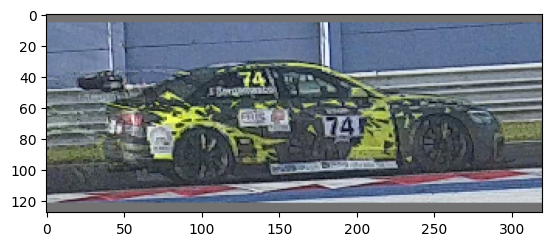

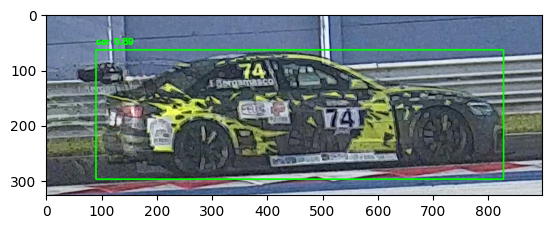

In [26]:
result = result[0]
if hasattr(result.boxes.data, "cpu"):
    boxes = result.boxes.data.cpu().numpy()
else:
    boxes = result.boxes.data

cars = [];

for box in boxes:
    x1, y1, x2, y2, conf, cls = box
    x1_orig = int((x1 - dw) / scale)
    y1_orig = int((y1 - dh) / scale)
    x2_orig = int((x2 - dw) / scale)
    y2_orig = int((y2 - dh) / scale)

    
    # Recupera il nome della classe, se disponibile (il modello potrebbe avere l'attributo names)
    if hasattr(model, "names") and int(cls) in model.names:
        label = model.names[int(cls)]
    else:
        label = str(int(cls))
    
    if label == "car":
        cars.append(image[y1_orig:y2_orig, x1_orig:x2_orig])

    # Disegna il rettangolo (bounding box) in verde
    cv2.rectangle(image, (x1_orig, y1_orig), (x2_orig, y2_orig), (0, 255, 0), 2)
    # Inserisci l'etichetta con la classe e la confidenza sopra il rettangolo
    cv2.putText(image, f"{label} {conf:.2f}", (x1_orig, y1_orig - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

import matplotlib.pyplot as plt

plt.imshow(letterboxed_image)
plt.show()
plt.imshow(image)
plt.show()

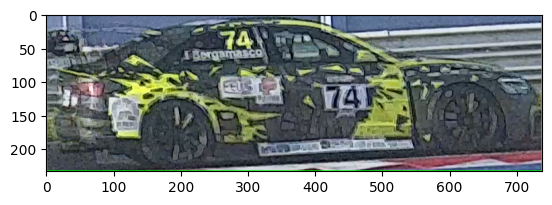

In [27]:
for car in cars:
    plt.imshow(car)
    plt.show()

In [ ]:
import numpy as np


def new_thres(h1 = 98, s1 = 0, v1 = 127, h2 = 155, s2 = 90, v2 = 255):
    hsv = cv2.cvtColor(cars[0], cv2.COLOR_BGR2HSV)
    lower_white = np.array([h1, s1, v1])
    upper_white = np.array([h2, s2, v2])

    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    plt.imshow(mask, cmap="gray")
    plt.show()

    return mask


from ipywidgets import interactive, IntSlider
from IPython.display import display

h1 = IntSlider(min=0, max=179, value=98)
s1 = IntSlider(min=0, max=255, value=0)
v1 = IntSlider(min=0, max=255, value=127)

h2 = IntSlider(min=0, max=179, value=155)
s2 = IntSlider(min=0, max=255, value=90)
v2 = IntSlider(min=0, max=255, value=255)

thres_viewer = interactive(new_thres, h1 = h1, s1 = s1, v1 = v1, h2 = h2, s2 = s2, v2 = v2)
display(thres_viewer)


interactive(children=(IntSlider(value=98, description='h1', max=179), IntSlider(value=0, description='s1', max…

In [42]:
thres = thres_viewer.result

In [43]:

"""
Calcola i contorni nell'immagine e li approssima secondo un epsilon fissato
Restituisce un array con tutti i pezzi di immagine che potrebbero contenere il box con il numero
"""
def calc_epsilon(image, e = 0.07110000000000001):
    contours, _ = cv2.findContours( image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    converted = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(converted, contours, -1, (255, 0, 0), 3)

    angles = []
    approxed = []

    for contour in contours:
        epsilon = e * cv2.arcLength(contour, False)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        x, y, w, h = cv2.boundingRect(approx)

        areaRect = cv2.minAreaRect(approx)
        angle = areaRect[2]

        if w > 30 and w < 100 and h > 20 and h < 60:
            cv2.drawContours(converted, [approx], -1, (0, 255, 0), 3)
            cut = image[y:y+h, x:x+w]

            approxed.append(cut)
            angles.append(- angle)
                

    plt.imshow(converted)
    plt.show()
    return approxed, angles

In [ ]:
from ipywidgets import FloatSlider, fixed
contours_viewer = interactive(calc_epsilon,image = fixed(thres), e=FloatSlider(min=0.0001, max=0.1, value=0.07110000000000001, step=0.001))

display(contours_viewer)

interactive(children=(FloatSlider(value=0.07110000000000001, description='e', max=0.1, min=0.0001, step=0.001)…

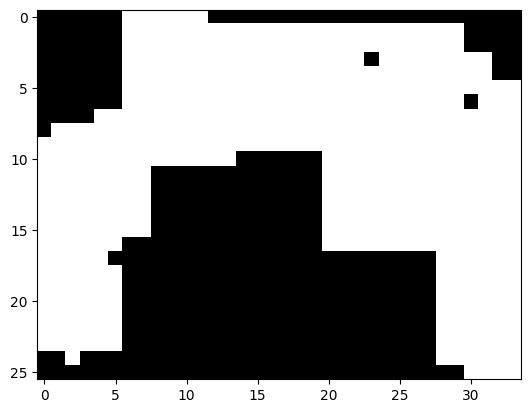

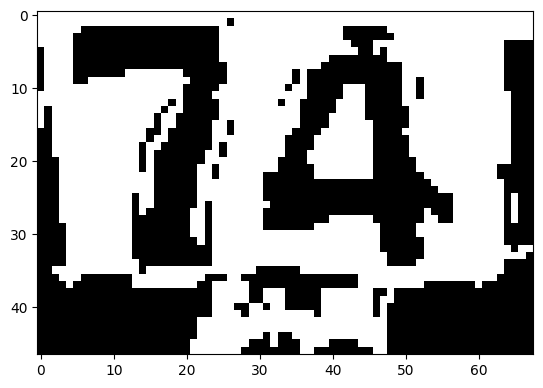

74


In [45]:
import pytesseract

# oem 3 indica di utilizzare il motore di default
# psm 7 indica che il testo che stiamo leggendo è composto da una sola riga
# tessedit_char_whitelist indica la lisa dei caratteri ammessi
custom_oem_psm_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789 --tessdata-dir C:\\Users\\michi\\Desktop\\riconoscimento_numeri\\models\\'

boxes, angles = contours_viewer.result
for box in boxes:
    plt.imshow(box, "gray")
    plt.show()
    

    text = pytesseract.image_to_string(box, config=custom_oem_psm_config)
    print(text.strip())

14


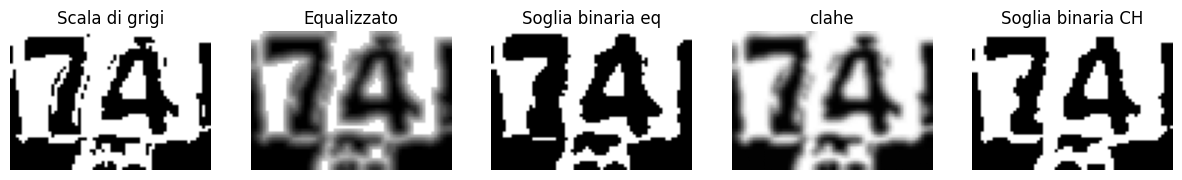

In [49]:
gray = boxes[1]
# Applicare un filtro Gaussiano per ridurre il rumore
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Equalizzazione dell'istogramma per migliorare il contrasto
equalized = cv2.equalizeHist(blurred)

# Equalizzazione adattiva dell'istogramma
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(blurred)  # Miglioramento del contrasto

# Applicare la soglia binaria di Otsu
_, thresholded = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, enh_thres = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Mostrare i risultati intermedi
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Scala di grigi")

axes[1].imshow(equalized, cmap='gray')
axes[1].set_title("Equalizzato")

axes[2].imshow(thresholded, cmap='gray')
axes[2].set_title("Soglia binaria eq")

axes[3].imshow(enhanced, cmap='gray')
axes[3].set_title("clahe")

axes[4].imshow(enh_thres, cmap='gray')
axes[4].set_title("Soglia binaria CH")

for ax in axes:
    ax.axis("off")
text = pytesseract.image_to_string(enh_thres, config=custom_oem_psm_config)
print(text.strip())
plt.show()

Found  10 contours
96.5
31.0
0.0
0.0
262.5
93.5
9.0
0.0
407.5
268.0


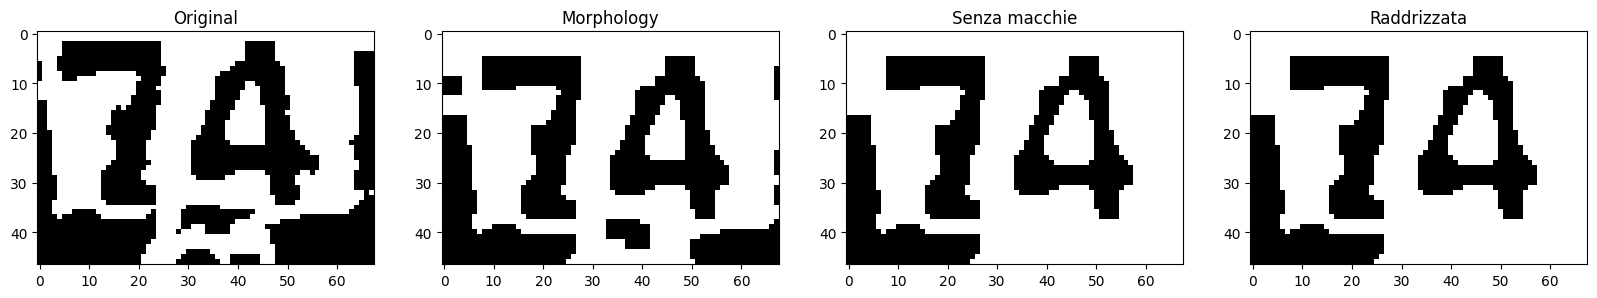

numero riconosciuto: 114


In [48]:
kernel = np.ones((2,2), np.uint8)

# Applicare una dilatazione e una erosione per rimuovere piccoli artefatti
dilated = cv2.morphologyEx(enh_thres, cv2.MORPH_CLOSE, kernel, iterations=3)

# Creare una copia bianco su nero
copy = cv2.bitwise_not(dilated)

# Trovare tutti i contorni dell'immagine e rimuovere quelli più piccoli (i numeri saranno le macchie più grandi)
contours, _ = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print("Found ", len(contours), "contours")

for c in contours:
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)
    print(area)

    if area < 200:
        cv2.drawContours(copy, [c], 0, 0, -1)


# Ruotare l'immagine per raddrizzare i numeri, l'angolo di rotazione viene individuato quando vengono riconosciuti i box
(height, width) = copy.shape[:2]
center = (width // 2, height // 2)
rotation_mat = cv2.getRotationMatrix2D(center, angles[0], 1)
#result = cv2.warpAffine(copy, rotation_mat, copy.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=(0,0,0))

# Fare tornare l'immagine da bianco su nero a nero su bianco
result = cv2.bitwise_not(copy)

# Mostrare i risultati intermedi
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(enh_thres, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(dilated, cmap='gray')
axes[1].set_title("Morphology")

axes[2].imshow(cv2.bitwise_not(copy), "gray")
axes[2].set_title("Senza macchie")

axes[3].imshow(result, "gray")
axes[3].set_title("Raddrizzata")
plt.show()


text = pytesseract.image_to_string(result, config=custom_oem_psm_config)
print("numero riconosciuto:",text.strip())